In [408]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import math
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

pd.set_option('display.max_columns', 500)

In [363]:
class Model:
    def __init__(self, cat_features_indices, params={'n_estimators': 500, 'learning_rate': 0.07}):
        self.cat_features_indices = cat_features_indices
        self.params = params
        
    def fit(self, X, y):
        pool = Pool(X, y, cat_features=self.cat_features_indices)
        self.model = CatBoostClassifier()
        self.model.set_params(**self.params)
        
        self.model.fit(pool)
        
    def predict(self, X):
        pool = Pool(X, cat_features=self.cat_features_indices)
        
        pred = self.model.predict_proba(pool)[:, 1]
        return pred
    
    def score(self, X, y):
        pred = self.predict(X)
        
        roc_auc_value = roc_auc_score(y, pred)
        log_loss_value = log_loss(y, pred)
        return roc_auc_value, log_loss_value
    
    def cross_validate(self, X, y):
        roc_auc_list = []
        log_loss_list = []
        kf = RepeatedStratifiedKFold(5, 5, random_state=1)
        
        for train_idx, test_idx in kf.split(X, y):
            X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            
            self.fit(X_train, y_train)
            ra, ll = self.score(X_test, y_test)
            
            roc_auc_list.append(ra)
            log_loss_list.append(ll)
        
        self.fit(X, y)
            
        print('ROC AUC: {}'.format(np.mean(roc_auc_list)))
        print('LOG LOSS: {}'.format(np.mean(log_loss_list)))
        print('roc auc folds std: {}'.format(np.std(roc_auc_list)))
        print('log loss folds std: {}'.format(np.std(log_loss_list)))
        return self.model

In [486]:
def get_deadline(row):
    if row['wave_id'] == 1:
        return row['Level'] < 7
    if row['wave_id'] == 2:
        return row['Level'] < 5
    if row['wave_id'] == 3:
        return row['Level'] < 4
    return False

def trimAndReplaceCity(city):
    if pd.isna(city) :
        return ''
    city = city.lstrip()
    if city.lower().__contains__('москв') :
        return 'Москва'
    if city.lower().__contains__('Moscow') :
        return 'Москва'
    if city.find('г.') > -1:
        return city.replace('г.', ' ').strip()
    if city.find('с.') > -1:
        return city.replace('с.', ' ').strip()
    if city.find('С.') > -1:
        return city.replace('С.', ' ').strip()
    if city.find('п.') > -1:
        return city.replace('п.', ' ').strip()
    if city.find('дер.') > -1:
        return city.replace('дер.', ' ').strip()
    if city.find('Дер.') > -1:
        return city.replace('Дер.', ' ').strip()
    if city.find('Г.') > -1:
        return city.replace('Г.', ' ').strip()
    return city

def prep_features(data):
    df = data.copy().rename({'Native city': 'city',
                             'Wave id': 'wave_id'}, axis=1)
    cities = pd.read_csv('data/cities_features.csv', names=['city', 'f1', 'f2','f3', 'f4','f5', 'f6', 'f7', 'f8'])
    cities = cities.sort_values(by='f1', ascending=False).drop_duplicates('city', keep='first')
    df = df.merge(cities, on='city', how='left')
    df.index = data.index
    df['city'] = df['city'].apply(trimAndReplaceCity)
    df['age'] = ((datetime.now() - df['Birth date']).dt.days / 365).apply(math.floor)
    df['contract'] = df['Contract termination date'].isna().astype('int64')
    df['Life status'] = df['Life status'].astype(str)
    df['fail_deadline'] = df.apply(get_deadline, axis=1).astype(int)
    df['total_days'] = df[['day_00', 'day_01', 'day_02', 'day_03', 'day_04',
                           'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
                           'day_10', 'day_11', 'day_12', 'day_13']].sum(axis=1)
    df['total_solo_projects'] = df[['evalexpr', 'match_n_match', 'bsq']].sum(axis=1)
    df['total_rushes'] = df[['rush_00', 'rush_01', 'rush_02']].sum(axis=1)
    df['total_exams'] = df[['exam_00', 'exam_01', 'exam_02', 'exam_final']].sum(axis=1)
    df['total_all_projects'] = df[['total_days', 'total_solo_projects',
                                   'total_rushes', 'total_exams']].sum(axis=1)
    df['nan_projects'] = df[['day_00', 'day_01', 'day_02', 'day_03', 'day_04',
                             'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
                             'day_10', 'day_11', 'day_12', 'day_13',
                             'evalexpr', 'match_n_match', 'bsq',
                             'rush_00', 'rush_01', 'rush_02',
                             'exam_00', 'exam_01', 'exam_02', 'exam_final']].isna().sum(axis=1)
    df['zero_projects'] = (df[['day_00', 'day_01', 'day_02', 'day_03', 'day_04',
                              'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
                              'day_10', 'day_11', 'day_12', 'day_13',
                              'evalexpr', 'match_n_match', 'bsq',
                              'rush_00', 'rush_01', 'rush_02',
                              'exam_00', 'exam_01', 'exam_02', 'exam_final']] == 0).sum(axis=1)
#     df['lvl_wave_id'] = df['Level']..astype(str) + df['wave_id'].astype(str)
    return df

In [490]:
train = pd.read_csv('data/train.csv', index_col=0, parse_dates=[1])
features = ['age','Gender', 'Level', 'Life status',
#             'day_00', 'day_01', 'day_02', 'day_03', 'day_04',
#             'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
#             'day_10', 'day_11', 'day_12', 'day_13',
#             'evalexpr', 'match_n_match', 'bsq',
#             'rush_00', 'rush_01', 'rush_02',
            'exam_00', 'exam_01', 'exam_02', 'exam_final',
            'f1', 'f2','f3', 'f4','f5', 'f6', 'f7', 'f8',
            'total_days', 'total_solo_projects', 'total_rushes', 'total_exams', 'total_all_projects',
            'nan_projects', 'zero_projects',
            'contract', 'Memory entrance game',
            'Logic entrance game',
            'wave_id', 'fail_deadline'
           ]
data = prep_features(train)[features]
y = train['contract_status'].values

In [491]:
X = data

map_feature_index = {j:i for i,j in enumerate(X.columns)}
# cat_features = ['Gender', 'Life status']
cat_features = ['Gender', 'Life status', 'wave_id']
cat_features_indices = [map_feature_index[i] for i in cat_features]

model_params = {
    'random_state': 12,
    'n_estimators': 500,
    'learning_rate': 0.03,
    'depth': 5,
    'verbose': 500
}

model = Model(cat_features_indices, model_params)
model.cross_validate(X, y)

0:	learn: 0.6550274	total: 6.85ms	remaining: 3.42s
499:	learn: 0.0359040	total: 1.48s	remaining: 0us
0:	learn: 0.6503567	total: 2.3ms	remaining: 1.15s
499:	learn: 0.0384837	total: 1.19s	remaining: 0us
0:	learn: 0.6532713	total: 2.56ms	remaining: 1.28s
499:	learn: 0.0293304	total: 1.41s	remaining: 0us
0:	learn: 0.6551754	total: 4.67ms	remaining: 2.33s
499:	learn: 0.0367159	total: 1.3s	remaining: 0us
0:	learn: 0.6538064	total: 2.3ms	remaining: 1.15s
499:	learn: 0.0353341	total: 1.54s	remaining: 0us
0:	learn: 0.6558166	total: 2.24ms	remaining: 1.12s
499:	learn: 0.0390433	total: 1.24s	remaining: 0us
0:	learn: 0.6552227	total: 2.43ms	remaining: 1.21s
499:	learn: 0.0317743	total: 1.38s	remaining: 0us
0:	learn: 0.6559360	total: 2.5ms	remaining: 1.25s
499:	learn: 0.0411071	total: 2.27s	remaining: 0us
0:	learn: 0.6520471	total: 4.58ms	remaining: 2.29s
499:	learn: 0.0366087	total: 1.44s	remaining: 0us
0:	learn: 0.6547840	total: 2.29ms	remaining: 1.14s
499:	learn: 0.0353865	total: 1.26s	remaining

In [505]:
def make_prediction_file(model):
    test = pd.read_csv('data/test.csv', index_col=0, parse_dates=[1])
    
    test_df = prep_features(test)[features]
    pred = 1 - model.predict(test_df)
    pd.DataFrame(pred, index=test_df.index).reset_index().to_csv('prediction.csv', header=['id', 'contract_status'], index=False)
    return pred


In [506]:
pred = make_prediction_file(model)

In [501]:
roc_auc_list = []
log_loss_list = []
kf = RepeatedStratifiedKFold(5, 5, random_state=1)

X_tmp = X.copy()
X_tmp['Gender'] = X_tmp['Gender'].map({'male': 1, 'female': 0})
X_tmp['Life status'] = X_tmp['Life status'].map({'work': 0, 'nan': 1, 'other': 2, 'study': 3})

lgb_params = {
    'random_state': 42,
    'objective': 'binary',
    'metric': 'logloss',
    'verbosity': -1,
    'num_rounds': 500
}

for train_idx, test_idx in kf.split(X_tmp, y):
    X_train, X_test = X_tmp.iloc[train_idx, :], X_tmp.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

    train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    eval_lgb = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features)
    
    lgb_model = lgb.train(lgb_params, train_lgb, verbose_eval=50, num_boost_round=500, valid_sets=eval_lgb)
    pred = lgb_model.predict(X_test)
    ra = roc_auc_score(y_test, pred)
    ll = log_loss(y_test, pred)

    roc_auc_list.append(ra)
    log_loss_list.append(ll)

# self.fit(X, y)

print('ROC AUC: {}'.format(np.mean(roc_auc_list)))
print('LOG LOSS: {}'.format(np.mean(log_loss_list)))
print('roc auc folds std: {}'.format(np.std(roc_auc_list)))
print('log loss folds std: {}'.format(np.std(log_loss_list)))

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/ligh

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/ligh

ROC AUC: 0.9507343064416268
LOG LOSS: 0.4326213346330157
roc auc folds std: 0.021835714555659486
log loss folds std: 0.12528222676820164


In [498]:
train_lgb = lgb.Dataset(X_tmp, label=y, categorical_feature=cat_features)

lgb_model = lgb.train(lgb_params, train_lgb, verbose_eval=50, num_boost_round=500)
test = pd.read_csv('data/test.csv', index_col=0, parse_dates=[1])
test_df = prep_features(test)[features]
test_df['Gender'] = test_df['Gender'].map({'male': 1, 'female': 0})
test_df['Life status'] = test_df['Life status'].map({'work': 0, 'nan': 1, 'other': 2, 'study': 3})
pred = lgb_model.predict(test_df)
pd.DataFrame(pred, index=test_df.index).reset_index().to_csv('prediction.csv', header=['id', 'contract_status'], index=False)

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [380]:
def get_feature_importance(model):
    feature_importance = model.model.get_feature_importance(Pool(X,label=y, cat_features=cat_features_indices))
    feature_score = pd.DataFrame(list(zip(X.dtypes.index, feature_importance)), 
                                 columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score',
                                              ascending=False,
                                              inplace=False,
                                              kind='quicksort',
                                              na_position='last')
    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()
    return feature_score

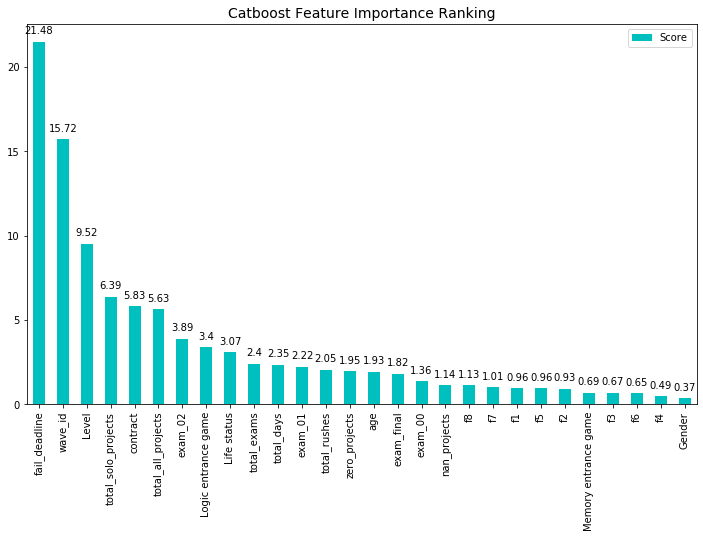

,Feature,Score
27,fail_deadline,21.482875
26,wave_id,15.724638
2,Level,9.520184
17,total_solo_projects,6.385847
23,contract,5.826539
20,total_all_projects,5.627643
6,exam_02,3.891668
25,Logic entrance game,3.396658
3,Life status,3.073588
19,total_exams,2.398445


In [381]:
get_feature_importance(model)

In [303]:
cols = ['day_00', 'day_01', 'day_02',
       'day_03', 'day_04', 'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
       'day_10', 'day_11', 'day_12', 'day_13', 'evalexpr', 'match_n_match',
       'bsq', 'rush_00', 'rush_01', 'rush_02', 'exam_00', 'exam_01', 'exam_02',
       'exam_final']

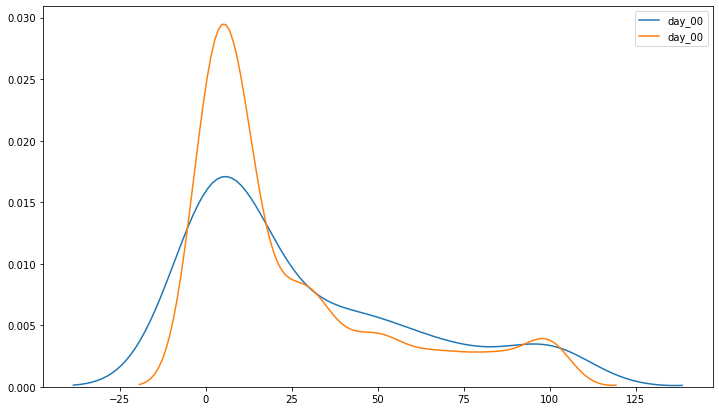

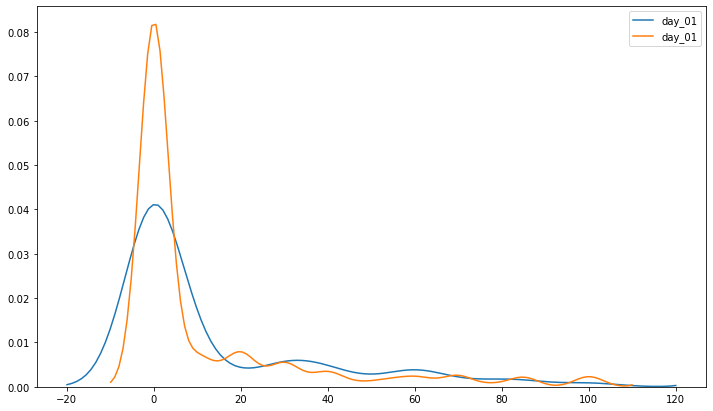

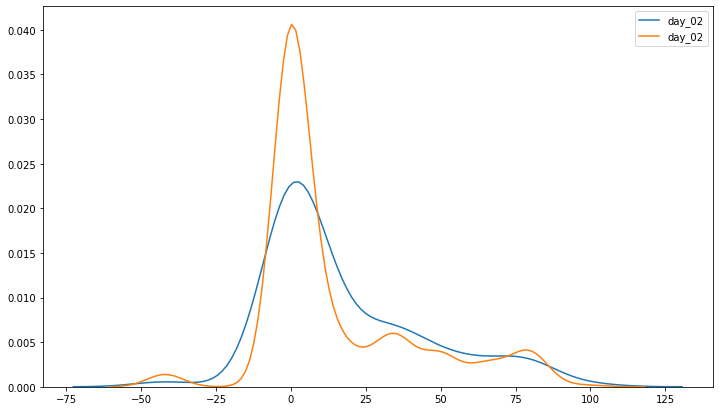

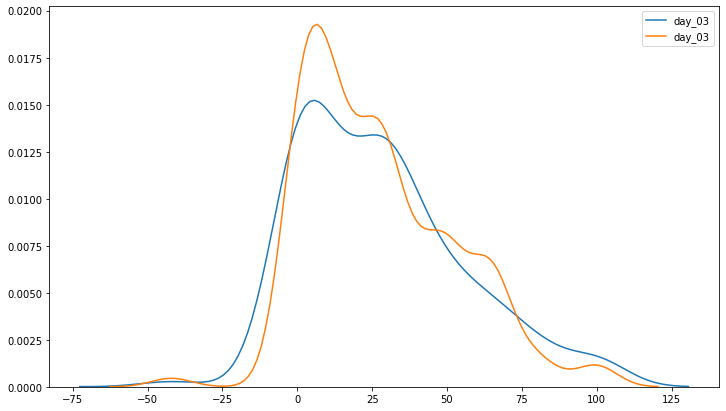

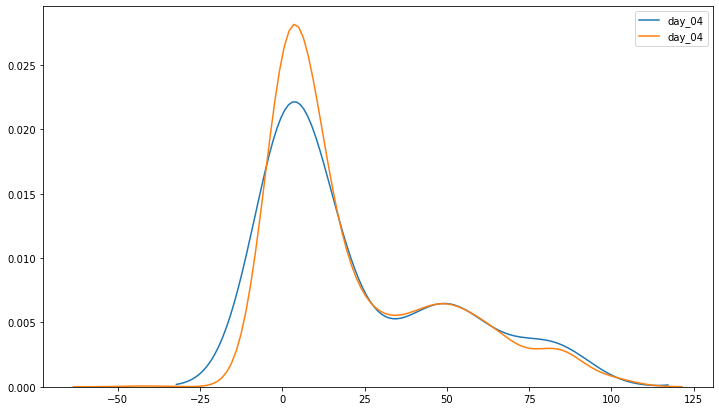

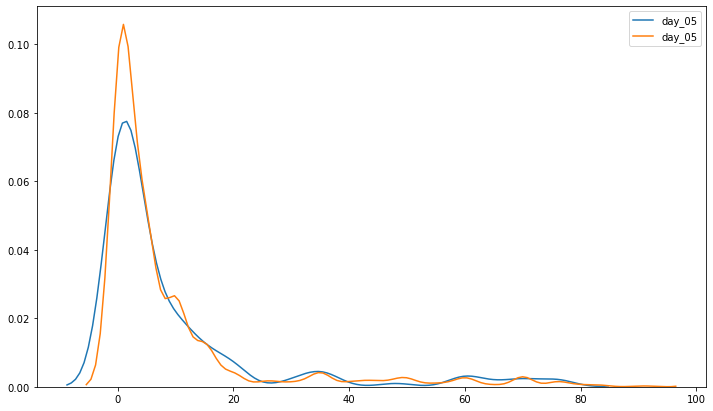

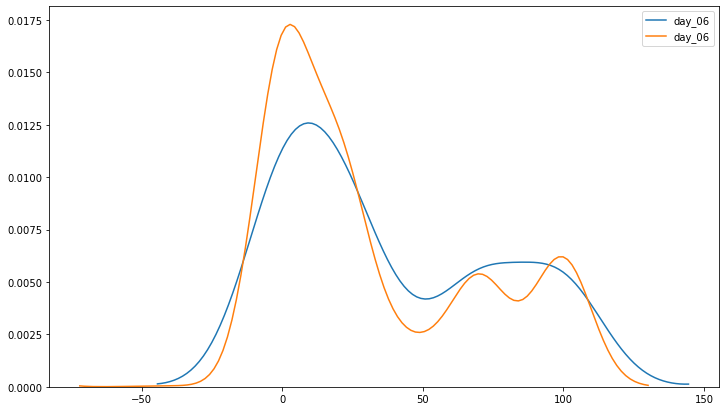

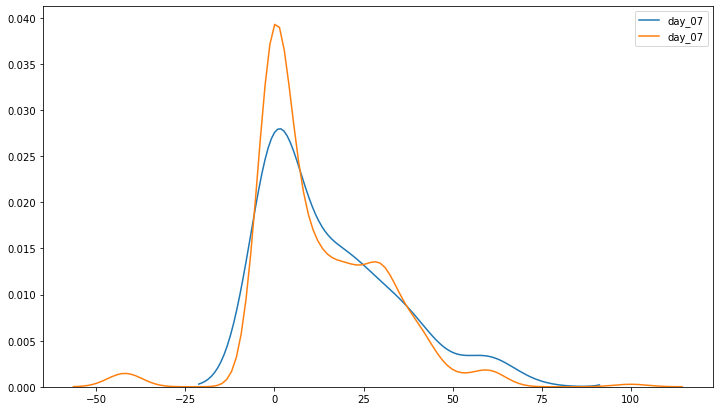

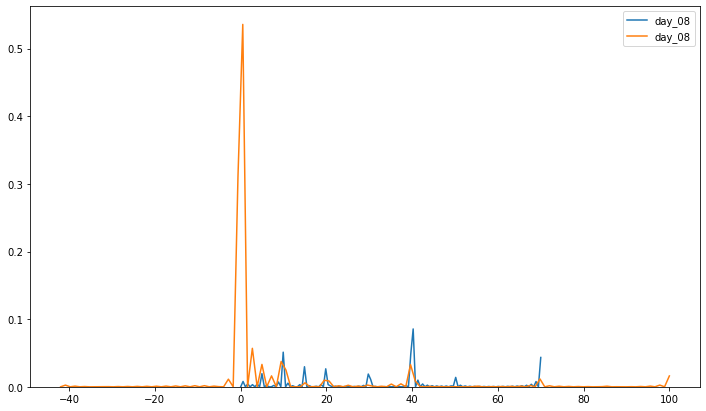

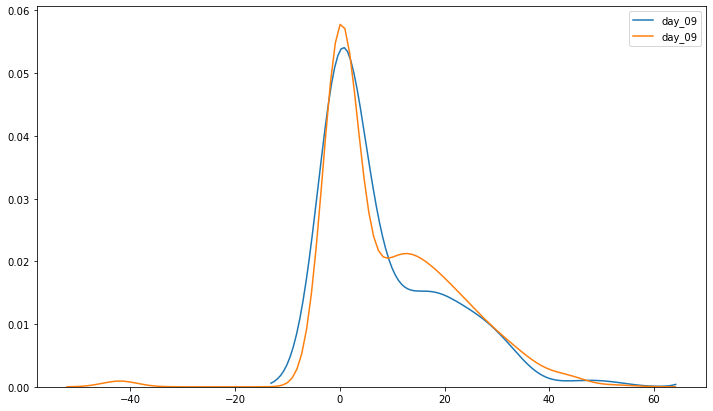

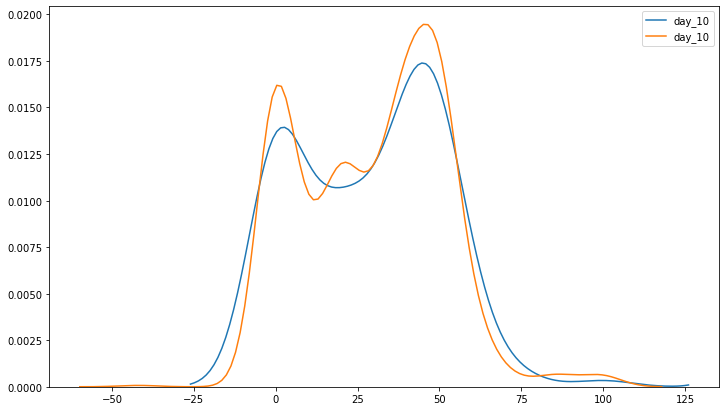

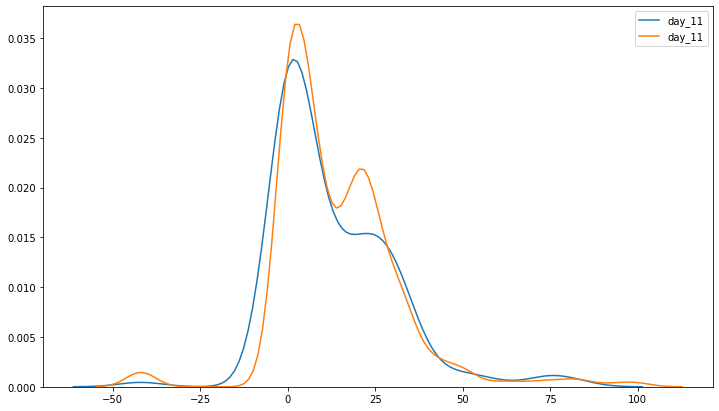

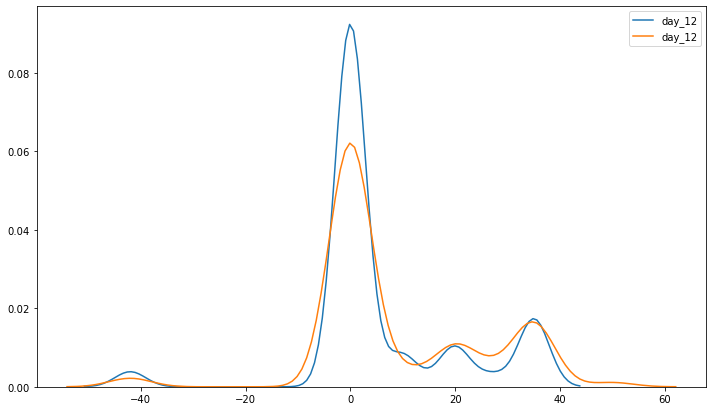

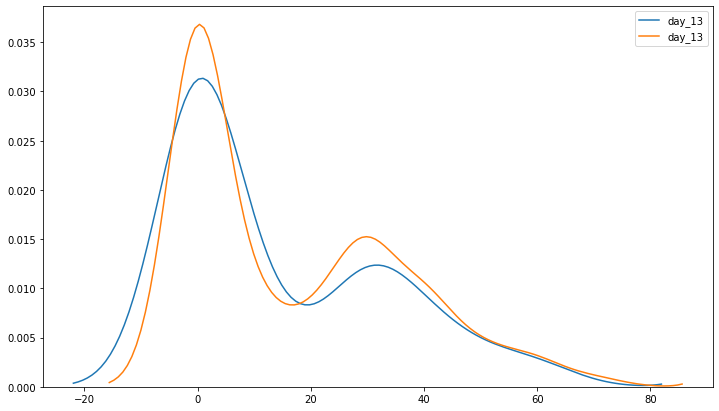

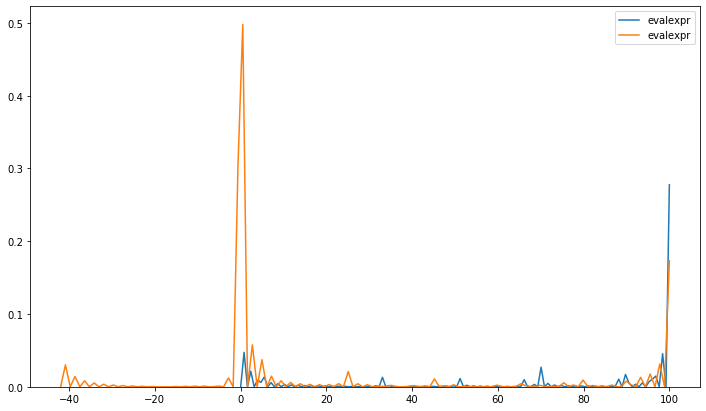

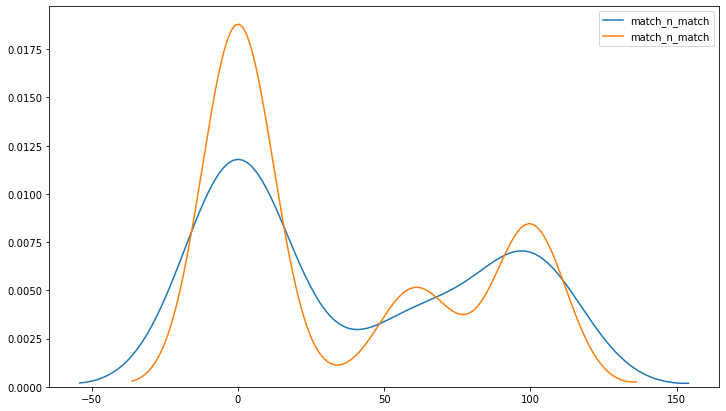

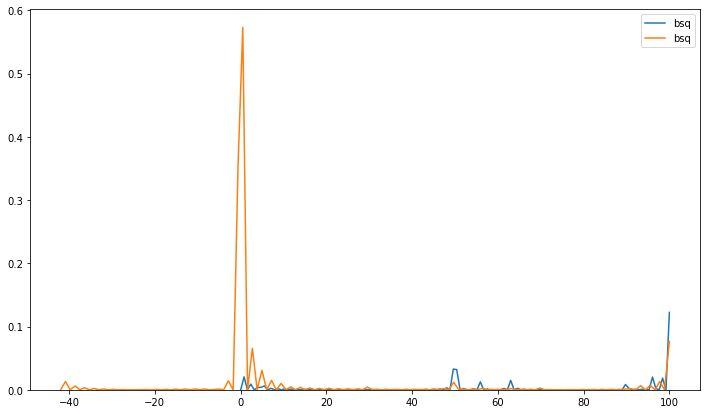

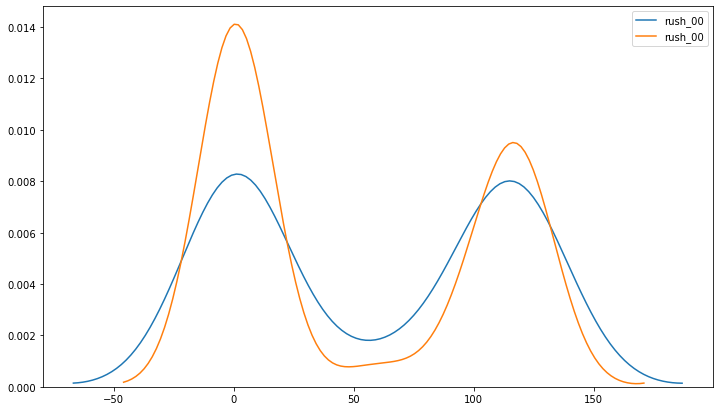

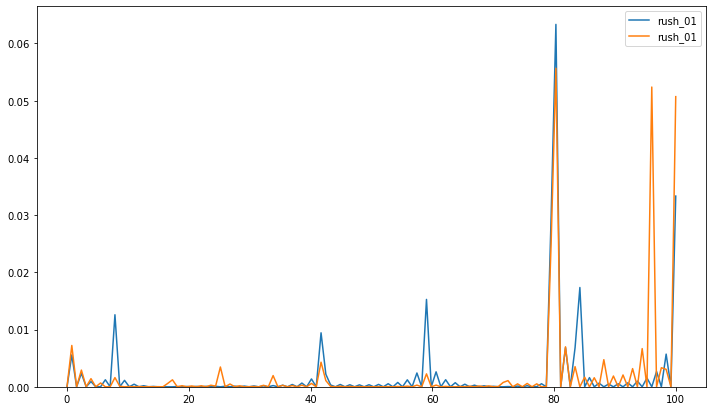

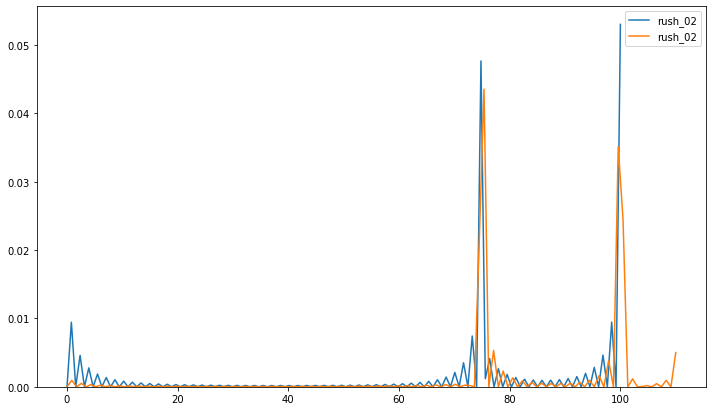

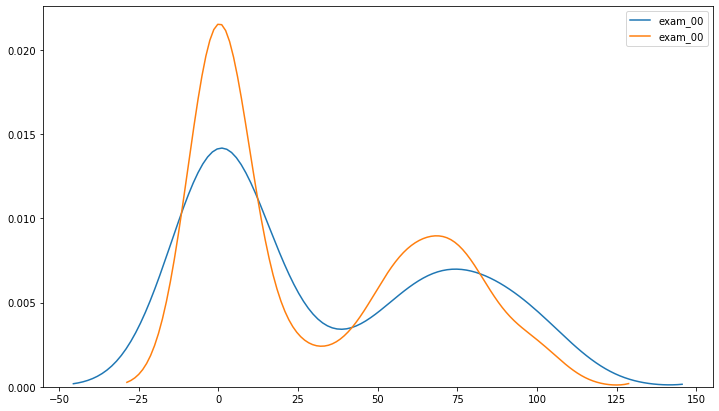

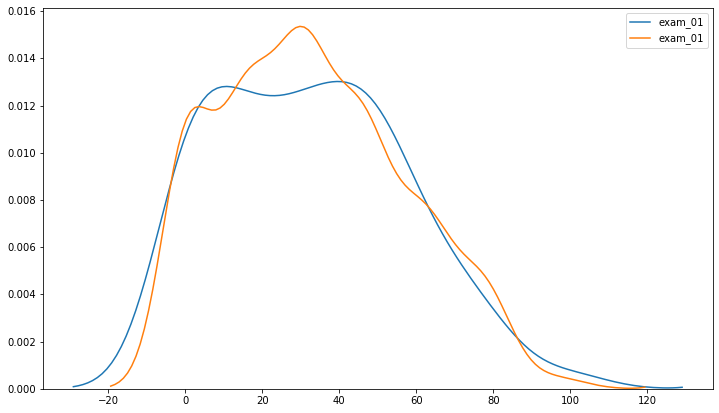

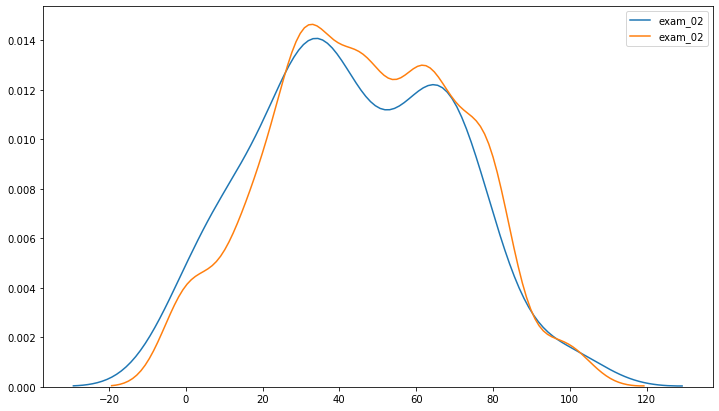

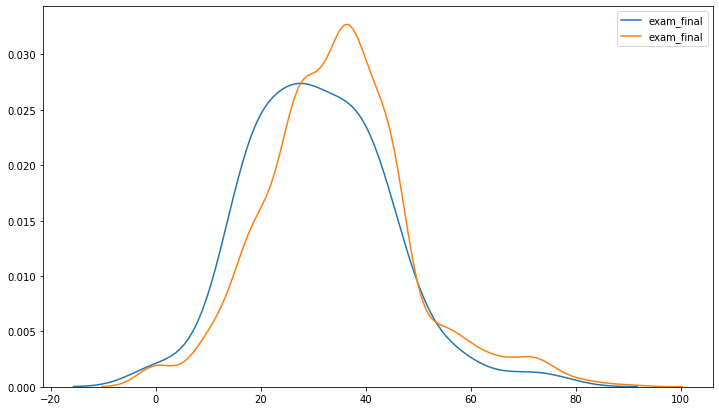

In [313]:
for n in cols:
    sns.kdeplot(train[train['contract_status'] == 0][n], label=n)
    sns.kdeplot(train[train['contract_status'] == 1][n], label=n)
    plt.show()

In [306]:
sns.kdeplot?